In [3]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Adam = optimizers.Adam(lr=0.001)

In [4]:
csv_path_train = 'trainset/J0003_0024_0222_20110307012737_cell_7.csv'
csv_path_test = 'testset/J0003_0024_0221_20110307012732_cell_03.csv'
df = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

date_time = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
date_time_test = pd.to_datetime(df_test.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')

In [5]:
df.head()

,CellNo,Resistance,Volt,Temp
0,7,0.296,2.25,-20
1,7,0.297,2.25,-20
2,7,0.298,2.25,-20
3,7,0.298,2.25,-20
4,7,0.296,2.25,-20


In [6]:
df_test.head()

,CellNo,Resistance,Volt,Temp
0,3,0.298,2.23,-20
1,3,0.298,2.23,-20
2,3,0.297,2.24,-20
3,3,0.299,2.23,-20
4,3,0.298,2.24,-20


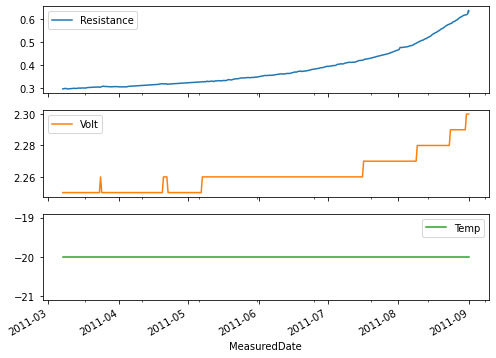

In [7]:
plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


array([<AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>], dtype=object)

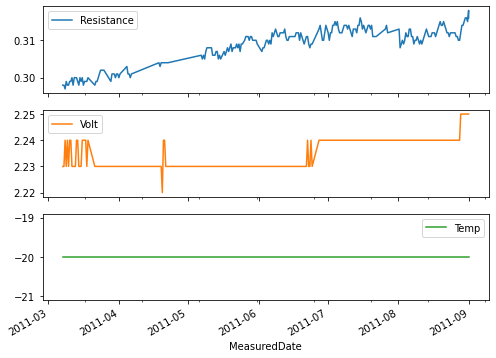

In [8]:
#plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features_test = df_test[plot_cols]
plot_features_test.index = date_time_test
plot_features_test.plot(subplots=True)

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CellNo,255.0,7.000000,0.000000,7.000,7.00,7.000,7.0000,7.000
Resistance,255.0,0.400443,0.092912,0.296,0.33,0.372,0.4475,0.639
Volt,255.0,2.263725,0.011766,2.250,2.26,2.260,2.2700,2.300
Temp,255.0,-20.000000,0.000000,-20.000,-20.00,-20.000,-20.0000,-20.000


In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices = {name: i for i, name in enumerate(df_test.columns)}

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df[plot_cols])
df_test = scaler.fit_transform(df_test[plot_cols])
df = pd.DataFrame(df)
df_test = pd.DataFrame(df_test)
df.columns = plot_cols
df_test.columns = plot_cols

In [12]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.8)]
test_df = df[int(n*0.8):]
#n_test = len(df_test)
test_df_test = df_test[:int(n*0.7)]
label_df = df_test[int(n*0.7):]

num_features = df.shape[1]
#print(int(n*0.8),int(n*0.2),len(test_df), len(label_df))

In [13]:
df.head()

,Resistance,Volt,Temp
0,0.000000,0.0,0.0
1,0.002915,0.0,0.0
2,0.005831,0.0,0.0
3,0.005831,0.0,0.0
4,0.000000,0.0,0.0


<AxesSubplot:>

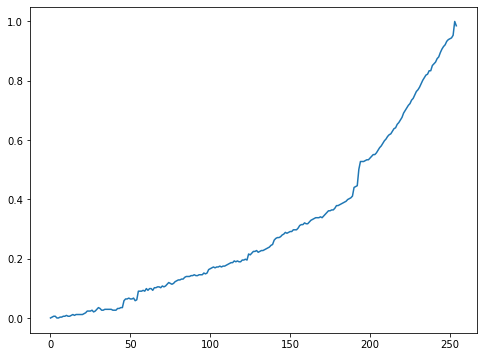

In [14]:
df['Resistance'].plot()

In [15]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [16]:
#w1 = WindowGenerator(input_width = 28, label_width=28, shift=1, label_columns = ['Resistance'])
#w1

In [17]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [18]:
def plot(self, model=None, plot_col='Resistance', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    max_n=1
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(self.label_indices, labels[n, :, label_col_index], label='Labels', c='#2ca02c', zorder=-10)
                #edgecolors='k', c='#2ca02c', s=1)
        if model is not None:
            predictions = model(inputs)
            plt.plot(self.label_indices, predictions[n, :, label_col_index], label='Predictions', c='#ff7f0e', zorder=-10)
                   
             #           edgecolors='k', label='Predictions',
              #    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [19]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets = None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [20]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

def test_test(self):
    return self.make_dataset(self.test_df_test)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.test_test = test_test

Total window size: 174
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
Label indices: [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173]
Label column name(s): None

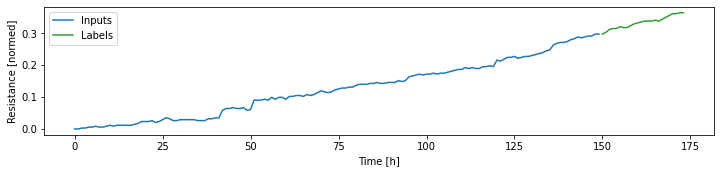

In [21]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=150,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

In [22]:
MAX_EPOCHS = 1500

def compile_and_fit(model, window, patience=500):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    # optimizer=tf.optimizers.Adam(),
                    optimizer=Adam,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [23]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(32, activation='relu', kernel_initializer='he_normal', dropout=0.1, return_sequences=False),
    # tf.keras.layers.Dropout(rate=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [24]:
history = compile_and_fit(model, multi_window)

Epoch 1/1500
1/1 [==============================] - 5s 5s/step - loss: 0.0494 - mean_absolute_error: 0.1761
Epoch 2/1500
1/1 [==============================] - 0s 115ms/step - loss: 0.0486 - mean_absolute_error: 0.1746
Epoch 3/1500
1/1 [==============================] - 0s 116ms/step - loss: 0.0478 - mean_absolute_error: 0.1731
Epoch 4/1500
1/1 [==============================] - 0s 119ms/step - loss: 0.0470 - mean_absolute_error: 0.1715
Epoch 5/1500
1/1 [==============================] - 0s 126ms/step - loss: 0.0461 - mean_absolute_error: 0.1697
Epoch 6/1500
1/1 [==============================] - 0s 125ms/step - loss: 0.0451 - mean_absolute_error: 0.1678
Epoch 7/1500
1/1 [==============================] - 0s 126ms/step - loss: 0.0441 - mean_absolute_error: 0.1658
Epoch 8/1500
1/1 [==============================] - 0s 130ms/step - loss: 0.0430 - mean_absolute_error: 0.1635
Epoch 9/1500
1/1 [==============================] - 0s 136ms/step - loss: 0.0418 - mean_absolute_error: 0.1611
Epoc

Epoch 34/1500
1/1 [==============================] - 0s 105ms/step - loss: 1.6364e-04 - mean_absolute_error: 0.0092
Epoch 35/1500
1/1 [==============================] - 0s 110ms/step - loss: 2.9433e-05 - mean_absolute_error: 0.0037
Epoch 36/1500
1/1 [==============================] - 0s 131ms/step - loss: 1.1336e-04 - mean_absolute_error: 0.0081
Epoch 37/1500
1/1 [==============================] - 0s 146ms/step - loss: 3.1367e-04 - mean_absolute_error: 0.0143
Epoch 38/1500
1/1 [==============================] - 0s 134ms/step - loss: 5.4442e-04 - mean_absolute_error: 0.0189
Epoch 39/1500
1/1 [==============================] - 0s 126ms/step - loss: 7.4551e-04 - mean_absolute_error: 0.0221
Epoch 40/1500
1/1 [==============================] - 0s 117ms/step - loss: 8.8297e-04 - mean_absolute_error: 0.0240
Epoch 41/1500
1/1 [==============================] - 0s 103ms/step - loss: 9.4449e-04 - mean_absolute_error: 0.0247
Epoch 42/1500
1/1 [==============================] - 0s 110ms/step - los

1/1 [==============================] - 0s 118ms/step - loss: 8.8409e-06 - mean_absolute_error: 0.0020
Epoch 99/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.0490e-06 - mean_absolute_error: 0.0019
Epoch 100/1500
1/1 [==============================] - 0s 111ms/step - loss: 7.4959e-06 - mean_absolute_error: 0.0017
Epoch 101/1500
1/1 [==============================] - 0s 112ms/step - loss: 7.1872e-06 - mean_absolute_error: 0.0015
Epoch 102/1500
1/1 [==============================] - 0s 119ms/step - loss: 7.0750e-06 - mean_absolute_error: 0.0014
Epoch 103/1500
1/1 [==============================] - 0s 123ms/step - loss: 7.0808e-06 - mean_absolute_error: 0.0013
Epoch 104/1500
1/1 [==============================] - 0s 117ms/step - loss: 7.1227e-06 - mean_absolute_error: 0.0013
Epoch 105/1500
1/1 [==============================] - 0s 120ms/step - loss: 7.1367e-06 - mean_absolute_error: 0.0014
Epoch 106/1500
1/1 [==============================] - 0s 116ms/step - loss: 7.09

1/1 [==============================] - 0s 103ms/step - loss: 6.2759e-06 - mean_absolute_error: 0.0012
Epoch 163/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.2748e-06 - mean_absolute_error: 0.0012
Epoch 164/1500
1/1 [==============================] - 0s 103ms/step - loss: 6.2739e-06 - mean_absolute_error: 0.0012
Epoch 165/1500
1/1 [==============================] - 0s 103ms/step - loss: 6.2732e-06 - mean_absolute_error: 0.0012
Epoch 166/1500
1/1 [==============================] - 0s 106ms/step - loss: 6.2729e-06 - mean_absolute_error: 0.0012
Epoch 167/1500
1/1 [==============================] - 0s 124ms/step - loss: 6.2730e-06 - mean_absolute_error: 0.0012
Epoch 168/1500
1/1 [==============================] - 0s 113ms/step - loss: 6.2733e-06 - mean_absolute_error: 0.0012
Epoch 169/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.2737e-06 - mean_absolute_error: 0.0012
Epoch 170/1500
1/1 [==============================] - 0s 105ms/step - loss: 6.2

1/1 [==============================] - 0s 117ms/step - loss: 6.2677e-06 - mean_absolute_error: 0.0012
Epoch 227/1500
1/1 [==============================] - 0s 103ms/step - loss: 6.2676e-06 - mean_absolute_error: 0.0012
Epoch 228/1500
1/1 [==============================] - 0s 119ms/step - loss: 6.2675e-06 - mean_absolute_error: 0.0012
Epoch 229/1500
1/1 [==============================] - 0s 110ms/step - loss: 6.2675e-06 - mean_absolute_error: 0.0012
Epoch 230/1500
1/1 [==============================] - 0s 106ms/step - loss: 6.2674e-06 - mean_absolute_error: 0.0012
Epoch 231/1500
1/1 [==============================] - 0s 113ms/step - loss: 6.2673e-06 - mean_absolute_error: 0.0012
Epoch 232/1500
1/1 [==============================] - 0s 113ms/step - loss: 6.2672e-06 - mean_absolute_error: 0.0012
Epoch 233/1500
1/1 [==============================] - 0s 120ms/step - loss: 6.2671e-06 - mean_absolute_error: 0.0012
Epoch 234/1500
1/1 [==============================] - 0s 118ms/step - loss: 6.2

1/1 [==============================] - 0s 104ms/step - loss: 6.2616e-06 - mean_absolute_error: 0.0012
Epoch 291/1500
1/1 [==============================] - 0s 102ms/step - loss: 6.2615e-06 - mean_absolute_error: 0.0012
Epoch 292/1500
1/1 [==============================] - 0s 101ms/step - loss: 6.2614e-06 - mean_absolute_error: 0.0012
Epoch 293/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.2613e-06 - mean_absolute_error: 0.0012
Epoch 294/1500
1/1 [==============================] - 0s 104ms/step - loss: 6.2612e-06 - mean_absolute_error: 0.0012
Epoch 295/1500
1/1 [==============================] - 0s 105ms/step - loss: 6.2611e-06 - mean_absolute_error: 0.0012
Epoch 296/1500
1/1 [==============================] - 0s 103ms/step - loss: 6.2610e-06 - mean_absolute_error: 0.0012
Epoch 297/1500
1/1 [==============================] - 0s 104ms/step - loss: 6.2609e-06 - mean_absolute_error: 0.0012
Epoch 298/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.2

1/1 [==============================] - 0s 111ms/step - loss: 6.2547e-06 - mean_absolute_error: 0.0012
Epoch 355/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.2546e-06 - mean_absolute_error: 0.0012
Epoch 356/1500
1/1 [==============================] - 0s 106ms/step - loss: 6.2544e-06 - mean_absolute_error: 0.0012
Epoch 357/1500
1/1 [==============================] - 0s 113ms/step - loss: 6.2543e-06 - mean_absolute_error: 0.0012
Epoch 358/1500
1/1 [==============================] - 0s 113ms/step - loss: 6.2542e-06 - mean_absolute_error: 0.0012
Epoch 359/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.2541e-06 - mean_absolute_error: 0.0012
Epoch 360/1500
1/1 [==============================] - 0s 113ms/step - loss: 6.2540e-06 - mean_absolute_error: 0.0012
Epoch 361/1500
1/1 [==============================] - 0s 112ms/step - loss: 6.2539e-06 - mean_absolute_error: 0.0012
Epoch 362/1500
1/1 [==============================] - 0s 117ms/step - loss: 6.2

1/1 [==============================] - 0s 112ms/step - loss: 6.2469e-06 - mean_absolute_error: 0.0012
Epoch 419/1500
1/1 [==============================] - 0s 116ms/step - loss: 6.2468e-06 - mean_absolute_error: 0.0012
Epoch 420/1500
1/1 [==============================] - 0s 102ms/step - loss: 6.2466e-06 - mean_absolute_error: 0.0012
Epoch 421/1500
1/1 [==============================] - 0s 110ms/step - loss: 6.2465e-06 - mean_absolute_error: 0.0012
Epoch 422/1500
1/1 [==============================] - 0s 125ms/step - loss: 6.2464e-06 - mean_absolute_error: 0.0012
Epoch 423/1500
1/1 [==============================] - 0s 105ms/step - loss: 6.2463e-06 - mean_absolute_error: 0.0012
Epoch 424/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.2461e-06 - mean_absolute_error: 0.0012
Epoch 425/1500
1/1 [==============================] - 0s 110ms/step - loss: 6.2460e-06 - mean_absolute_error: 0.0012
Epoch 426/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.2

1/1 [==============================] - 0s 119ms/step - loss: 6.2383e-06 - mean_absolute_error: 0.0012
Epoch 483/1500
1/1 [==============================] - 0s 119ms/step - loss: 6.2382e-06 - mean_absolute_error: 0.0012
Epoch 484/1500
1/1 [==============================] - 0s 126ms/step - loss: 6.2380e-06 - mean_absolute_error: 0.0012
Epoch 485/1500
1/1 [==============================] - 0s 128ms/step - loss: 6.2379e-06 - mean_absolute_error: 0.0012
Epoch 486/1500
1/1 [==============================] - 0s 121ms/step - loss: 6.2377e-06 - mean_absolute_error: 0.0012
Epoch 487/1500
1/1 [==============================] - 0s 118ms/step - loss: 6.2376e-06 - mean_absolute_error: 0.0012
Epoch 488/1500
1/1 [==============================] - 0s 114ms/step - loss: 6.2375e-06 - mean_absolute_error: 0.0012
Epoch 489/1500
1/1 [==============================] - 0s 126ms/step - loss: 6.2373e-06 - mean_absolute_error: 0.0012
Epoch 490/1500
1/1 [==============================] - 0s 112ms/step - loss: 6.2

1/1 [==============================] - 0s 93ms/step - loss: 6.2290e-06 - mean_absolute_error: 0.0012
Epoch 547/1500
1/1 [==============================] - 0s 96ms/step - loss: 6.2288e-06 - mean_absolute_error: 0.0012
Epoch 548/1500
1/1 [==============================] - 0s 100ms/step - loss: 6.2286e-06 - mean_absolute_error: 0.0012
Epoch 549/1500
1/1 [==============================] - 0s 95ms/step - loss: 6.2285e-06 - mean_absolute_error: 0.0012
Epoch 550/1500
1/1 [==============================] - 0s 102ms/step - loss: 6.2283e-06 - mean_absolute_error: 0.0012
Epoch 551/1500
1/1 [==============================] - 0s 95ms/step - loss: 6.2282e-06 - mean_absolute_error: 0.0012
Epoch 552/1500
1/1 [==============================] - 0s 106ms/step - loss: 6.2281e-06 - mean_absolute_error: 0.0012
Epoch 553/1500
1/1 [==============================] - 0s 96ms/step - loss: 6.2279e-06 - mean_absolute_error: 0.0012
Epoch 554/1500
1/1 [==============================] - 0s 124ms/step - loss: 6.2277e-

1/1 [==============================] - 0s 101ms/step - loss: 6.2188e-06 - mean_absolute_error: 0.0012
Epoch 611/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.2187e-06 - mean_absolute_error: 0.0012
Epoch 612/1500
1/1 [==============================] - 0s 104ms/step - loss: 6.2185e-06 - mean_absolute_error: 0.0012
Epoch 613/1500
1/1 [==============================] - 0s 115ms/step - loss: 6.2183e-06 - mean_absolute_error: 0.0012
Epoch 614/1500
1/1 [==============================] - 0s 108ms/step - loss: 6.2182e-06 - mean_absolute_error: 0.0012
Epoch 615/1500
1/1 [==============================] - 0s 106ms/step - loss: 6.2180e-06 - mean_absolute_error: 0.0012
Epoch 616/1500
1/1 [==============================] - 0s 104ms/step - loss: 6.2178e-06 - mean_absolute_error: 0.0012
Epoch 617/1500
1/1 [==============================] - 0s 101ms/step - loss: 6.2177e-06 - mean_absolute_error: 0.0012
Epoch 618/1500
1/1 [==============================] - 0s 102ms/step - loss: 6.2

1/1 [==============================] - 0s 103ms/step - loss: 6.2079e-06 - mean_absolute_error: 0.0012
Epoch 675/1500
1/1 [==============================] - 0s 102ms/step - loss: 6.2077e-06 - mean_absolute_error: 0.0012
Epoch 676/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.2075e-06 - mean_absolute_error: 0.0012
Epoch 677/1500
1/1 [==============================] - 0s 100ms/step - loss: 6.2074e-06 - mean_absolute_error: 0.0012
Epoch 678/1500
1/1 [==============================] - 0s 104ms/step - loss: 6.2072e-06 - mean_absolute_error: 0.0012
Epoch 679/1500
1/1 [==============================] - 0s 98ms/step - loss: 6.2070e-06 - mean_absolute_error: 0.0012
Epoch 680/1500
1/1 [==============================] - 0s 108ms/step - loss: 6.2068e-06 - mean_absolute_error: 0.0012
Epoch 681/1500
1/1 [==============================] - 0s 103ms/step - loss: 6.2066e-06 - mean_absolute_error: 0.0012
Epoch 682/1500
1/1 [==============================] - 0s 103ms/step - loss: 6.20

1/1 [==============================] - 0s 110ms/step - loss: 6.1961e-06 - mean_absolute_error: 0.0012
Epoch 739/1500
1/1 [==============================] - 0s 104ms/step - loss: 6.1959e-06 - mean_absolute_error: 0.0012
Epoch 740/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.1957e-06 - mean_absolute_error: 0.0012
Epoch 741/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.1956e-06 - mean_absolute_error: 0.0012
Epoch 742/1500
1/1 [==============================] - 0s 108ms/step - loss: 6.1954e-06 - mean_absolute_error: 0.0012
Epoch 743/1500
1/1 [==============================] - 0s 105ms/step - loss: 6.1952e-06 - mean_absolute_error: 0.0012
Epoch 744/1500
1/1 [==============================] - 0s 112ms/step - loss: 6.1950e-06 - mean_absolute_error: 0.0012
Epoch 745/1500
1/1 [==============================] - 0s 114ms/step - loss: 6.1948e-06 - mean_absolute_error: 0.0012
Epoch 746/1500
1/1 [==============================] - 0s 108ms/step - loss: 6.1

1/1 [==============================] - 0s 101ms/step - loss: 6.1836e-06 - mean_absolute_error: 0.0012
Epoch 803/1500
1/1 [==============================] - 0s 96ms/step - loss: 6.1834e-06 - mean_absolute_error: 0.0012
Epoch 804/1500
1/1 [==============================] - 0s 98ms/step - loss: 6.1832e-06 - mean_absolute_error: 0.0012
Epoch 805/1500
1/1 [==============================] - 0s 97ms/step - loss: 6.1830e-06 - mean_absolute_error: 0.0012
Epoch 806/1500
1/1 [==============================] - 0s 97ms/step - loss: 6.1827e-06 - mean_absolute_error: 0.0012
Epoch 807/1500
1/1 [==============================] - 0s 102ms/step - loss: 6.1826e-06 - mean_absolute_error: 0.0012
Epoch 808/1500
1/1 [==============================] - 0s 104ms/step - loss: 6.1824e-06 - mean_absolute_error: 0.0012
Epoch 809/1500
1/1 [==============================] - 0s 105ms/step - loss: 6.1822e-06 - mean_absolute_error: 0.0012
Epoch 810/1500
1/1 [==============================] - 0s 142ms/step - loss: 6.1819e

1/1 [==============================] - 0s 103ms/step - loss: 6.1702e-06 - mean_absolute_error: 0.0012
Epoch 867/1500
1/1 [==============================] - 0s 108ms/step - loss: 6.1700e-06 - mean_absolute_error: 0.0012
Epoch 868/1500
1/1 [==============================] - 0s 103ms/step - loss: 6.1698e-06 - mean_absolute_error: 0.0012
Epoch 869/1500
1/1 [==============================] - 0s 103ms/step - loss: 6.1695e-06 - mean_absolute_error: 0.0012
Epoch 870/1500
1/1 [==============================] - 0s 103ms/step - loss: 6.1693e-06 - mean_absolute_error: 0.0012
Epoch 871/1500
1/1 [==============================] - 0s 106ms/step - loss: 6.1691e-06 - mean_absolute_error: 0.0012
Epoch 872/1500
1/1 [==============================] - 0s 100ms/step - loss: 6.1689e-06 - mean_absolute_error: 0.0012
Epoch 873/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.1687e-06 - mean_absolute_error: 0.0012
Epoch 874/1500
1/1 [==============================] - 0s 118ms/step - loss: 6.1

1/1 [==============================] - 0s 112ms/step - loss: 6.1559e-06 - mean_absolute_error: 0.0012
Epoch 931/1500
1/1 [==============================] - 0s 108ms/step - loss: 6.1557e-06 - mean_absolute_error: 0.0012
Epoch 932/1500
1/1 [==============================] - 0s 106ms/step - loss: 6.1555e-06 - mean_absolute_error: 0.0012
Epoch 933/1500
1/1 [==============================] - 0s 105ms/step - loss: 6.1553e-06 - mean_absolute_error: 0.0012
Epoch 934/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.1550e-06 - mean_absolute_error: 0.0012
Epoch 935/1500
1/1 [==============================] - 0s 103ms/step - loss: 6.1548e-06 - mean_absolute_error: 0.0012
Epoch 936/1500
1/1 [==============================] - 0s 103ms/step - loss: 6.1546e-06 - mean_absolute_error: 0.0012
Epoch 937/1500
1/1 [==============================] - 0s 104ms/step - loss: 6.1544e-06 - mean_absolute_error: 0.0012
Epoch 938/1500
1/1 [==============================] - 0s 104ms/step - loss: 6.1

1/1 [==============================] - 0s 103ms/step - loss: 6.1409e-06 - mean_absolute_error: 0.0012
Epoch 995/1500
1/1 [==============================] - 0s 121ms/step - loss: 6.1406e-06 - mean_absolute_error: 0.0012
Epoch 996/1500
1/1 [==============================] - 0s 116ms/step - loss: 6.1404e-06 - mean_absolute_error: 0.0012
Epoch 997/1500
1/1 [==============================] - 0s 162ms/step - loss: 6.1401e-06 - mean_absolute_error: 0.0012
Epoch 998/1500
1/1 [==============================] - 0s 129ms/step - loss: 6.1399e-06 - mean_absolute_error: 0.0012
Epoch 999/1500
1/1 [==============================] - 0s 124ms/step - loss: 6.1396e-06 - mean_absolute_error: 0.0012
Epoch 1000/1500
1/1 [==============================] - 0s 110ms/step - loss: 6.1394e-06 - mean_absolute_error: 0.0012
Epoch 1001/1500
1/1 [==============================] - 0s 123ms/step - loss: 6.1391e-06 - mean_absolute_error: 0.0012
Epoch 1002/1500
1/1 [==============================] - 0s 127ms/step - loss: 

Epoch 1026/1500
1/1 [==============================] - 0s 105ms/step - loss: 6.1330e-06 - mean_absolute_error: 0.0012
Epoch 1027/1500
1/1 [==============================] - 0s 111ms/step - loss: 6.1327e-06 - mean_absolute_error: 0.0012
Epoch 1028/1500
1/1 [==============================] - 0s 116ms/step - loss: 6.1325e-06 - mean_absolute_error: 0.0012
Epoch 1029/1500
1/1 [==============================] - 0s 125ms/step - loss: 6.1322e-06 - mean_absolute_error: 0.0012
Epoch 1030/1500
1/1 [==============================] - 0s 105ms/step - loss: 6.1320e-06 - mean_absolute_error: 0.0012
Epoch 1031/1500
1/1 [==============================] - 0s 116ms/step - loss: 6.1317e-06 - mean_absolute_error: 0.0012
Epoch 1032/1500
1/1 [==============================] - 0s 122ms/step - loss: 6.1315e-06 - mean_absolute_error: 0.0012
Epoch 1033/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.1312e-06 - mean_absolute_error: 0.0012
Epoch 1034/1500
1/1 [==============================] - 0

Epoch 1058/1500
1/1 [==============================] - 0s 103ms/step - loss: 6.1248e-06 - mean_absolute_error: 0.0012
Epoch 1059/1500
1/1 [==============================] - 0s 110ms/step - loss: 6.1246e-06 - mean_absolute_error: 0.0012
Epoch 1060/1500
1/1 [==============================] - 0s 114ms/step - loss: 6.1243e-06 - mean_absolute_error: 0.0012
Epoch 1061/1500
1/1 [==============================] - 0s 112ms/step - loss: 6.1241e-06 - mean_absolute_error: 0.0012
Epoch 1062/1500
1/1 [==============================] - 0s 105ms/step - loss: 6.1238e-06 - mean_absolute_error: 0.0012
Epoch 1063/1500
1/1 [==============================] - 0s 103ms/step - loss: 6.1236e-06 - mean_absolute_error: 0.0012
Epoch 1064/1500
1/1 [==============================] - 0s 106ms/step - loss: 6.1233e-06 - mean_absolute_error: 0.0012
Epoch 1065/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.1230e-06 - mean_absolute_error: 0.0012
Epoch 1066/1500
1/1 [==============================] - 0

Epoch 1090/1500
1/1 [==============================] - 0s 123ms/step - loss: 6.1165e-06 - mean_absolute_error: 0.0012
Epoch 1091/1500
1/1 [==============================] - 0s 116ms/step - loss: 6.1162e-06 - mean_absolute_error: 0.0012
Epoch 1092/1500
1/1 [==============================] - 0s 129ms/step - loss: 6.1160e-06 - mean_absolute_error: 0.0012
Epoch 1093/1500
1/1 [==============================] - 0s 147ms/step - loss: 6.1157e-06 - mean_absolute_error: 0.0012
Epoch 1094/1500
1/1 [==============================] - 0s 163ms/step - loss: 6.1154e-06 - mean_absolute_error: 0.0012
Epoch 1095/1500
1/1 [==============================] - 0s 139ms/step - loss: 6.1152e-06 - mean_absolute_error: 0.0012
Epoch 1096/1500
1/1 [==============================] - 0s 135ms/step - loss: 6.1149e-06 - mean_absolute_error: 0.0012
Epoch 1097/1500
1/1 [==============================] - 0s 135ms/step - loss: 6.1147e-06 - mean_absolute_error: 0.0012
Epoch 1098/1500
1/1 [==============================] - 0

Epoch 1122/1500
1/1 [==============================] - 0s 125ms/step - loss: 6.1079e-06 - mean_absolute_error: 0.0012
Epoch 1123/1500
1/1 [==============================] - 0s 113ms/step - loss: 6.1077e-06 - mean_absolute_error: 0.0012
Epoch 1124/1500
1/1 [==============================] - 0s 112ms/step - loss: 6.1074e-06 - mean_absolute_error: 0.0012
Epoch 1125/1500
1/1 [==============================] - 0s 127ms/step - loss: 6.1071e-06 - mean_absolute_error: 0.0012
Epoch 1126/1500
1/1 [==============================] - 0s 121ms/step - loss: 6.1069e-06 - mean_absolute_error: 0.0012
Epoch 1127/1500
1/1 [==============================] - 0s 114ms/step - loss: 6.1066e-06 - mean_absolute_error: 0.0012
Epoch 1128/1500
1/1 [==============================] - 0s 130ms/step - loss: 6.1063e-06 - mean_absolute_error: 0.0012
Epoch 1129/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.1060e-06 - mean_absolute_error: 0.0012
Epoch 1130/1500
1/1 [==============================] - 0

Epoch 1154/1500
1/1 [==============================] - 0s 119ms/step - loss: 6.0991e-06 - mean_absolute_error: 0.0012
Epoch 1155/1500
1/1 [==============================] - 0s 114ms/step - loss: 6.0988e-06 - mean_absolute_error: 0.0012
Epoch 1156/1500
1/1 [==============================] - 0s 116ms/step - loss: 6.0986e-06 - mean_absolute_error: 0.0012
Epoch 1157/1500
1/1 [==============================] - 0s 113ms/step - loss: 6.0983e-06 - mean_absolute_error: 0.0012
Epoch 1158/1500
1/1 [==============================] - 0s 114ms/step - loss: 6.0980e-06 - mean_absolute_error: 0.0012
Epoch 1159/1500
1/1 [==============================] - 0s 112ms/step - loss: 6.0977e-06 - mean_absolute_error: 0.0012
Epoch 1160/1500
1/1 [==============================] - 0s 119ms/step - loss: 6.0974e-06 - mean_absolute_error: 0.0012
Epoch 1161/1500
1/1 [==============================] - 0s 122ms/step - loss: 6.0972e-06 - mean_absolute_error: 0.0012
Epoch 1162/1500
1/1 [==============================] - 0

Epoch 1186/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.0901e-06 - mean_absolute_error: 0.0012
Epoch 1187/1500
1/1 [==============================] - 0s 118ms/step - loss: 6.0898e-06 - mean_absolute_error: 0.0012
Epoch 1188/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.0895e-06 - mean_absolute_error: 0.0012
Epoch 1189/1500
1/1 [==============================] - 0s 106ms/step - loss: 6.0892e-06 - mean_absolute_error: 0.0012
Epoch 1190/1500
1/1 [==============================] - 0s 115ms/step - loss: 6.0889e-06 - mean_absolute_error: 0.0012
Epoch 1191/1500
1/1 [==============================] - 0s 110ms/step - loss: 6.0886e-06 - mean_absolute_error: 0.0012
Epoch 1192/1500
1/1 [==============================] - 0s 112ms/step - loss: 6.0883e-06 - mean_absolute_error: 0.0012
Epoch 1193/1500
1/1 [==============================] - 0s 105ms/step - loss: 6.0880e-06 - mean_absolute_error: 0.0012
Epoch 1194/1500
1/1 [==============================] - 0

Epoch 1218/1500
1/1 [==============================] - 0s 130ms/step - loss: 6.0807e-06 - mean_absolute_error: 0.0012
Epoch 1219/1500
1/1 [==============================] - 0s 131ms/step - loss: 6.0804e-06 - mean_absolute_error: 0.0012
Epoch 1220/1500
1/1 [==============================] - 0s 116ms/step - loss: 6.0802e-06 - mean_absolute_error: 0.0012
Epoch 1221/1500
1/1 [==============================] - 0s 140ms/step - loss: 6.0799e-06 - mean_absolute_error: 0.0012
Epoch 1222/1500
1/1 [==============================] - 0s 136ms/step - loss: 6.0796e-06 - mean_absolute_error: 0.0012
Epoch 1223/1500
1/1 [==============================] - 0s 132ms/step - loss: 6.0793e-06 - mean_absolute_error: 0.0012
Epoch 1224/1500
1/1 [==============================] - 0s 136ms/step - loss: 6.0790e-06 - mean_absolute_error: 0.0012
Epoch 1225/1500
1/1 [==============================] - 0s 117ms/step - loss: 6.0787e-06 - mean_absolute_error: 0.0012
Epoch 1226/1500
1/1 [==============================] - 0

Epoch 1250/1500
1/1 [==============================] - 0s 117ms/step - loss: 6.0712e-06 - mean_absolute_error: 0.0012
Epoch 1251/1500
1/1 [==============================] - 0s 113ms/step - loss: 6.0709e-06 - mean_absolute_error: 0.0012
Epoch 1252/1500
1/1 [==============================] - 0s 119ms/step - loss: 6.0706e-06 - mean_absolute_error: 0.0012
Epoch 1253/1500
1/1 [==============================] - 0s 117ms/step - loss: 6.0703e-06 - mean_absolute_error: 0.0012
Epoch 1254/1500
1/1 [==============================] - 0s 121ms/step - loss: 6.0700e-06 - mean_absolute_error: 0.0012
Epoch 1255/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.0697e-06 - mean_absolute_error: 0.0012
Epoch 1256/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.0694e-06 - mean_absolute_error: 0.0012
Epoch 1257/1500
1/1 [==============================] - 0s 114ms/step - loss: 6.0691e-06 - mean_absolute_error: 0.0012
Epoch 1258/1500
1/1 [==============================] - 0

Epoch 1282/1500
1/1 [==============================] - 0s 116ms/step - loss: 6.0614e-06 - mean_absolute_error: 0.0012
Epoch 1283/1500
1/1 [==============================] - 0s 133ms/step - loss: 6.0611e-06 - mean_absolute_error: 0.0012
Epoch 1284/1500
1/1 [==============================] - 0s 122ms/step - loss: 6.0608e-06 - mean_absolute_error: 0.0012
Epoch 1285/1500
1/1 [==============================] - 0s 142ms/step - loss: 6.0605e-06 - mean_absolute_error: 0.0012
Epoch 1286/1500
1/1 [==============================] - 0s 118ms/step - loss: 6.0602e-06 - mean_absolute_error: 0.0012
Epoch 1287/1500
1/1 [==============================] - 0s 113ms/step - loss: 6.0598e-06 - mean_absolute_error: 0.0012
Epoch 1288/1500
1/1 [==============================] - 0s 123ms/step - loss: 6.0595e-06 - mean_absolute_error: 0.0012
Epoch 1289/1500
1/1 [==============================] - 0s 114ms/step - loss: 6.0592e-06 - mean_absolute_error: 0.0012
Epoch 1290/1500
1/1 [==============================] - 0

Epoch 1314/1500
1/1 [==============================] - 0s 131ms/step - loss: 6.0513e-06 - mean_absolute_error: 0.0012
Epoch 1315/1500
1/1 [==============================] - 0s 128ms/step - loss: 6.0510e-06 - mean_absolute_error: 0.0012
Epoch 1316/1500
1/1 [==============================] - 0s 132ms/step - loss: 6.0507e-06 - mean_absolute_error: 0.0012
Epoch 1317/1500
1/1 [==============================] - 0s 121ms/step - loss: 6.0504e-06 - mean_absolute_error: 0.0012
Epoch 1318/1500
1/1 [==============================] - 0s 132ms/step - loss: 6.0501e-06 - mean_absolute_error: 0.0012
Epoch 1319/1500
1/1 [==============================] - 0s 117ms/step - loss: 6.0497e-06 - mean_absolute_error: 0.0012
Epoch 1320/1500
1/1 [==============================] - 0s 143ms/step - loss: 6.0494e-06 - mean_absolute_error: 0.0012
Epoch 1321/1500
1/1 [==============================] - 0s 104ms/step - loss: 6.0491e-06 - mean_absolute_error: 0.0012
Epoch 1322/1500
1/1 [==============================] - 0

Epoch 1346/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.0410e-06 - mean_absolute_error: 0.0012
Epoch 1347/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.0407e-06 - mean_absolute_error: 0.0012
Epoch 1348/1500
1/1 [==============================] - 0s 116ms/step - loss: 6.0403e-06 - mean_absolute_error: 0.0012
Epoch 1349/1500
1/1 [==============================] - 0s 118ms/step - loss: 6.0400e-06 - mean_absolute_error: 0.0012
Epoch 1350/1500
1/1 [==============================] - 0s 108ms/step - loss: 6.0397e-06 - mean_absolute_error: 0.0012
Epoch 1351/1500
1/1 [==============================] - 0s 121ms/step - loss: 6.0393e-06 - mean_absolute_error: 0.0012
Epoch 1352/1500
1/1 [==============================] - 0s 143ms/step - loss: 6.0390e-06 - mean_absolute_error: 0.0012
Epoch 1353/1500
1/1 [==============================] - 0s 114ms/step - loss: 6.0387e-06 - mean_absolute_error: 0.0012
Epoch 1354/1500
1/1 [==============================] - 0

Epoch 1378/1500
1/1 [==============================] - 0s 126ms/step - loss: 6.0304e-06 - mean_absolute_error: 0.0012
Epoch 1379/1500
1/1 [==============================] - 0s 124ms/step - loss: 6.0300e-06 - mean_absolute_error: 0.0012
Epoch 1380/1500
1/1 [==============================] - 0s 124ms/step - loss: 6.0297e-06 - mean_absolute_error: 0.0012
Epoch 1381/1500
1/1 [==============================] - 0s 125ms/step - loss: 6.0294e-06 - mean_absolute_error: 0.0012
Epoch 1382/1500
1/1 [==============================] - 0s 126ms/step - loss: 6.0290e-06 - mean_absolute_error: 0.0012
Epoch 1383/1500
1/1 [==============================] - 0s 116ms/step - loss: 6.0287e-06 - mean_absolute_error: 0.0012
Epoch 1384/1500
1/1 [==============================] - 0s 124ms/step - loss: 6.0284e-06 - mean_absolute_error: 0.0012
Epoch 1385/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.0280e-06 - mean_absolute_error: 0.0012
Epoch 1386/1500
1/1 [==============================] - 0

Epoch 1410/1500
1/1 [==============================] - 0s 110ms/step - loss: 6.0195e-06 - mean_absolute_error: 0.0012
Epoch 1411/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.0192e-06 - mean_absolute_error: 0.0012
Epoch 1412/1500
1/1 [==============================] - 0s 106ms/step - loss: 6.0188e-06 - mean_absolute_error: 0.0012
Epoch 1413/1500
1/1 [==============================] - 0s 108ms/step - loss: 6.0185e-06 - mean_absolute_error: 0.0012
Epoch 1414/1500
1/1 [==============================] - 0s 108ms/step - loss: 6.0181e-06 - mean_absolute_error: 0.0012
Epoch 1415/1500
1/1 [==============================] - 0s 117ms/step - loss: 6.0178e-06 - mean_absolute_error: 0.0012
Epoch 1416/1500
1/1 [==============================] - 0s 106ms/step - loss: 6.0174e-06 - mean_absolute_error: 0.0012
Epoch 1417/1500
1/1 [==============================] - 0s 112ms/step - loss: 6.0171e-06 - mean_absolute_error: 0.0012
Epoch 1418/1500
1/1 [==============================] - 0

Epoch 1442/1500
1/1 [==============================] - 0s 108ms/step - loss: 6.0084e-06 - mean_absolute_error: 0.0012
Epoch 1443/1500
1/1 [==============================] - 0s 109ms/step - loss: 6.0080e-06 - mean_absolute_error: 0.0012
Epoch 1444/1500
1/1 [==============================] - 0s 113ms/step - loss: 6.0076e-06 - mean_absolute_error: 0.0012
Epoch 1445/1500
1/1 [==============================] - 0s 104ms/step - loss: 6.0073e-06 - mean_absolute_error: 0.0012
Epoch 1446/1500
1/1 [==============================] - 0s 111ms/step - loss: 6.0069e-06 - mean_absolute_error: 0.0012
Epoch 1447/1500
1/1 [==============================] - 0s 107ms/step - loss: 6.0066e-06 - mean_absolute_error: 0.0012
Epoch 1448/1500
1/1 [==============================] - 0s 104ms/step - loss: 6.0062e-06 - mean_absolute_error: 0.0012
Epoch 1449/1500
1/1 [==============================] - 0s 134ms/step - loss: 6.0059e-06 - mean_absolute_error: 0.0012
Epoch 1450/1500
1/1 [==============================] - 0

Epoch 1474/1500
1/1 [==============================] - 0s 124ms/step - loss: 5.9969e-06 - mean_absolute_error: 0.0012
Epoch 1475/1500
1/1 [==============================] - 0s 116ms/step - loss: 5.9966e-06 - mean_absolute_error: 0.0012
Epoch 1476/1500
1/1 [==============================] - 0s 123ms/step - loss: 5.9962e-06 - mean_absolute_error: 0.0012
Epoch 1477/1500
1/1 [==============================] - 0s 109ms/step - loss: 5.9958e-06 - mean_absolute_error: 0.0012
Epoch 1478/1500
1/1 [==============================] - 0s 122ms/step - loss: 5.9955e-06 - mean_absolute_error: 0.0012
Epoch 1479/1500
1/1 [==============================] - 0s 121ms/step - loss: 5.9951e-06 - mean_absolute_error: 0.0012
Epoch 1480/1500
1/1 [==============================] - 0s 132ms/step - loss: 5.9947e-06 - mean_absolute_error: 0.0012
Epoch 1481/1500
1/1 [==============================] - 0s 118ms/step - loss: 5.9944e-06 - mean_absolute_error: 0.0012
Epoch 1482/1500
1/1 [==============================] - 0

In [25]:
#pred = model.predict(test_df)

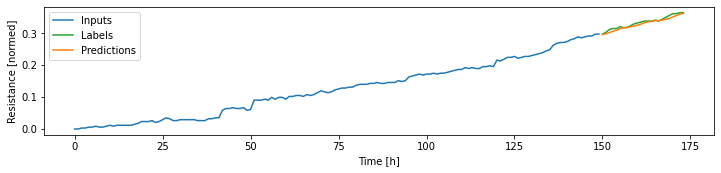

In [26]:
IPython.display.clear_output()

#multi_val_performance = model.evaluate(multi_window.val)
#multi_performance = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)

In [25]:
test_df_test.shape()

TypeError: 'tuple' object is not callable

In [ ]:
pred = model.predict(test_df_test)